In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.activations import relu
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import binary_accuracy
from tensorflow.keras.optimizers import RMSprop, Adam

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

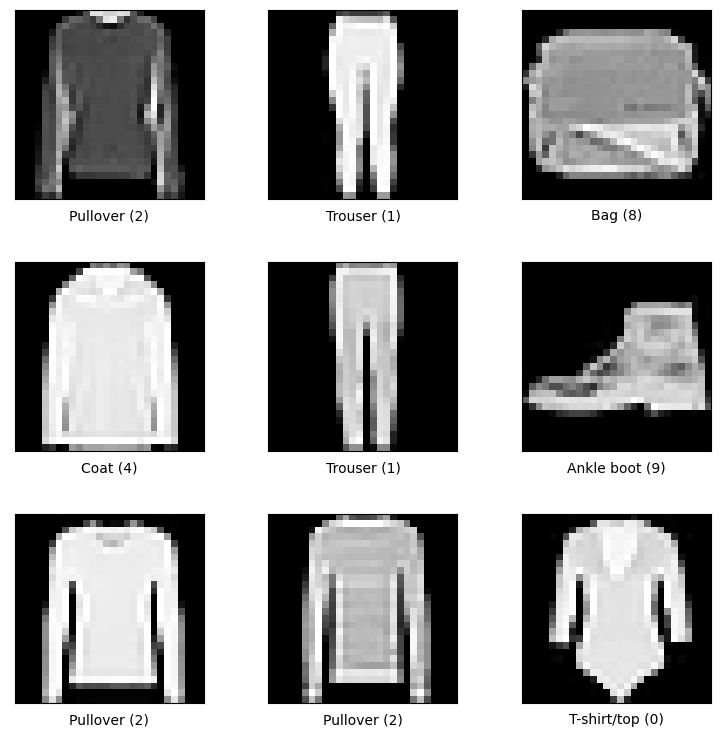

tfds.core.DatasetInfo(
    name='fashion_mnist',
    full_name='fashion_mnist/3.0.1',
    description="""
    Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.
    """,
    homepage='https://github.com/zalandoresearch/fashion-mnist',
    data_path='C:\\Users\\admin\\tensorflow_datasets\\fashion_mnist\\3.0.1',
    file_format=tfrecord,
    download_size=29.45 MiB,
    dataset_size=36.42 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{DBLP:journals/corr/abs-1708-077

In [2]:
ds_train, ds_info = tfds.load('fashion_mnist', split='train', shuffle_files=True, with_info=True)
fig = tfds.show_examples(ds_train, ds_info)
ds_info

In [3]:
batch_size = 200
image_shape = (28, 28 , 1)

In [4]:
def preprocess(features):
    image = tf.image.resize(features['image'], image_shape[:2])
    image = tf.cast(image, tf.float32)
    image = (image - 127.5) / 127.5
    return image

In [5]:
ds_train = ds_train.map(preprocess).cache().shuffle(ds_info.splits['train'].num_examples).batch(batch_size).repeat()

In [7]:
train_num = ds_info.splits['train'].num_examples
train_steps_per_epoch = round(train_num/batch_size)
print(train_steps_per_epoch)

300


In [36]:
class GAN():
    def __init__(self, generator, discriminator):
        # discirminator
        self.D = discriminator
        self.G = generator
        
        self.bce = tf.keras.losses.BinaryCrossentropy()
        self.d_loss = {}
        self.g_loss = {}
        self.accuracy = {}
        self.g_gradients = []
        
    def discriminator_loss(self, pred_fake, pred_real):
        real_loss = self.bce(tf.ones_like(pred_real), pred_real)
        fake_loss = self.bce(tf.zeros_like(pred_fake), pred_fake)
        
        d_loss = 0.5*(real_loss + fake_loss)
        return d_loss
    
    def generator_loss(self, pred_fake):
        g_loss = self.bce(tf.ones_like(pred_fake), pred_fake)
        return g_loss
    
    def train_step(self, g_input, real_input):
        
        with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
            # Feed forward
            fake_input = self.G(g_input)
            
            pred_fake = self.D(fake_input)
            pred_real = self.D(real_input)
            
            # Calculate losses
            d_loss = self.discriminator_loss(pred_fake, pred_real)
            g_loss = self.generator_loss(pred_fake)
            
            # Accuracy
            fake_accuracy = tf.math.reduce_mean(binary_accuracy(tf.zeros_like(pred_fake), pred_fake))
            real_accuracy = tf.math.reduce_mean(binary_accuracy(tf.ones_like(pred_real), pred_real))
            
            # backprop gradients
            gradient_g = g_tape.gradient(g_loss, self.G.trainable_variables)
            gradient_d = d_tape.gradient(d_loss, self.D.trainable_variables)
            
            gradient_g_l1_norm = [tf.norm(gradient).numpy() for gradient in gradient_g]
            self.g_gradients.append(gradient_g_l1_norm)
            
            # update weights
            self.G_optimizer.apply_gradients(zip(gradient_g, self.G.trainable_variables))
            self.D_optimizer.apply_gradients(zip(gradient_d, self.D.trainable_variables))
            
        return g_loss, d_loss, fake_accuracy, real_accuracy
    
    def train(self, data_generator, z_generator, g_optimizer, d_optimizer, steps, interval=100):
        self.D_optimizer = d_optimizer
        self.G_optimizer = g_optimizer
        val_g_input = next(z_generator)
        for i in range(steps):
            g_input = next(z_generator)
            real_input = next(data_generator)
            
            g_loss, d_loss, fake_accuracy, real_accuracy = self.train_step(g_input, real_input)
            self.d_loss[i] = d_loss.numpy()
            self.g_loss[i] = g_loss.numpy()
            self.accuracy[i] = 0.5 * (fake_accuracy.numpy() + real_accuracy.numpy())
            if i%interval == 0:
                msg = 'Step {}: d_loss {:.4f} g_loss {:.4f} Accracy. real: {:.3f} fake: {:.3f}'.format(i, d_loss, g_loss, real_accuracy, fake_accuracy)
                print(msg)
                
                fake_images = self.G(val_g_input)
                self.plot_images(fake_images)
                
    def plot_images(self, images):
        pass

In [37]:
class DCGAN(GAN):
    def __init__(self, z_dim, input_shape):
        
        discriminator = self.Discriminator(input_shape)
        generator = self.Generator(z_dim)
        
        GAN.__init__(self, generator, discriminator)
        
    def Discriminator(self, input_shape):
        
        model = tf.keras.Sequential(name='Discriminator')
        model.add(layers.Input(shape=input_shape))
        
        model.add(layers.Conv2D(32, 3, strides=(2,2), padding='same'))
        model.add(layers.BatchNormalization(momentum=0.9))
        model.add(layers.LeakyReLU(0.2))
        model.add(layers.Dropout(0.2))
        
        model.add(layers.Conv2D(64, 3, strides=(2,2), padding='same'))
        model.add(layers.BatchNormalization(momentum=0.9))
        model.add(layers.LeakyReLU(0.2))
        model.add(layers.Dropout(0.2))
        
        model.add(layers.Flatten())
        model.add(layers.Dense(1, activation='sigmoid'))
        
        return model
    
    def Generator(self, z_dim):
        
        model = tf.keras.Sequential(name='Generator')
        model.add(layers.Input(shape=[z_dim]))
        
        model.add(layers.Dense(7*7*64))
        model.add(layers.BatchNormalization(momentum=0.9))
        model.add(layers.ReLU())
        model.add(layers.Reshape((7,7,64)))
        
        model.add(layers.Conv2D(64, 3, padding='same'))
        model.add(layers.BatchNormalization(momentum=0.9))
        model.add(layers.ReLU())
        model.add(layers.UpSampling2D((2,2), interpolation='bilinear'))
        
        model.add(layers.Conv2D(32, 3, padding='same'))
        model.add(layers.ReLU())
        model.add(layers.UpSampling2D((2,2), interpolation='bilinear'))
        
        model.add(layers.Conv2D(image_shape[-1], 3, padding='same', activation='tanh'))
        
        return model
    
    def plot_images(self, images):
        grid_row = 1
        grid_col = 8
        f, axarr = plt.subplots(grid_row, grid_col, figsize=(grid_col*1.5, grid_row*1.5))
        for col in range(grid_col):
            axarr[col].imshow((images[col, :, :, 0] + 1)/2, cmap='gray')
            axarr[col].axis('off')
        plt.show()

In [38]:
z_dim = 100

In [39]:
def z_generator(batch_size, z_dim):
    while True:
        yield tf.random.normal((batch_size, z_dim))

In [40]:
z_gen = z_generator(batch_size, z_dim)

In [41]:
gan = DCGAN(z_dim, image_shape)

In [42]:
gan.D.summary()

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 14, 14, 32)        320       
                                                                 
 batch_normalization_12 (Bat  (None, 14, 14, 32)       128       
 chNormalization)                                                
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 14, 14, 32)        0         
                                                                 
 dropout_6 (Dropout)         (None, 14, 14, 32)        0         
                                                                 
 conv2d_16 (Conv2D)          (None, 7, 7, 64)          18496     
                                                                 
 batch_normalization_13 (Bat  (None, 7, 7, 64)         256       
 chNormalization)                                    

In [43]:
gan.G.summary()

Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 3136)              316736    
                                                                 
 batch_normalization_14 (Bat  (None, 3136)             12544     
 chNormalization)                                                
                                                                 
 re_lu_9 (ReLU)              (None, 3136)              0         
                                                                 
 reshape_3 (Reshape)         (None, 7, 7, 64)          0         
                                                                 
 conv2d_17 (Conv2D)          (None, 7, 7, 64)          36928     
                                                                 
 batch_normalization_15 (Bat  (None, 7, 7, 64)         256       
 chNormalization)                                        

Step 0: d_loss 0.7000 g_loss 0.6914 Accracy. real: 0.505 fake: 0.280


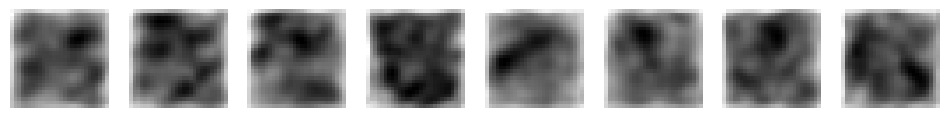

Step 600: d_loss 0.5199 g_loss 1.6439 Accracy. real: 0.385 fake: 1.000


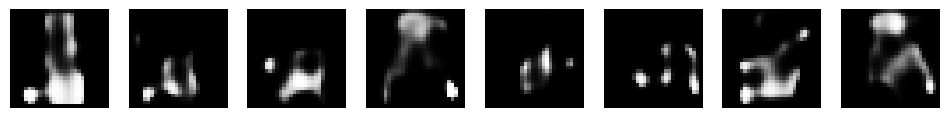

Step 1200: d_loss 0.5033 g_loss 1.1910 Accracy. real: 0.680 fake: 0.935


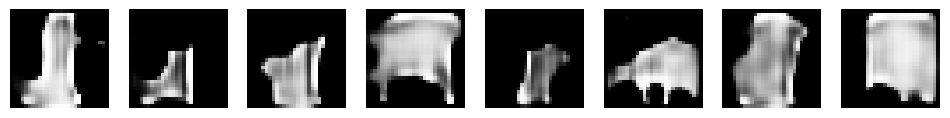

Step 1800: d_loss 0.5174 g_loss 0.9164 Accracy. real: 0.790 fake: 0.735


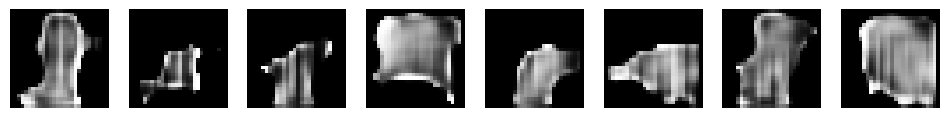

Step 2400: d_loss 0.4730 g_loss 1.6794 Accracy. real: 0.515 fake: 0.995


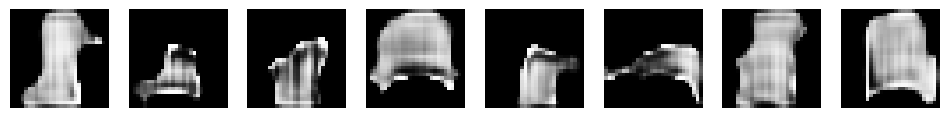

Step 3000: d_loss 0.5046 g_loss 1.0619 Accracy. real: 0.725 fake: 0.845


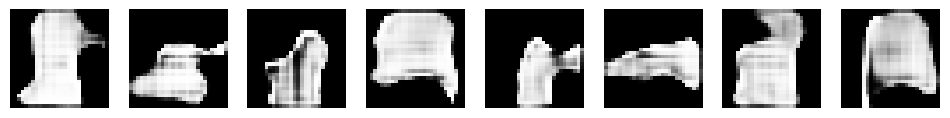

Step 3600: d_loss 0.4834 g_loss 1.2342 Accracy. real: 0.650 fake: 0.970


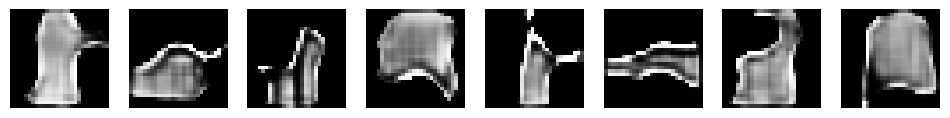

Step 4200: d_loss 0.5218 g_loss 1.7058 Accracy. real: 0.450 fake: 0.990


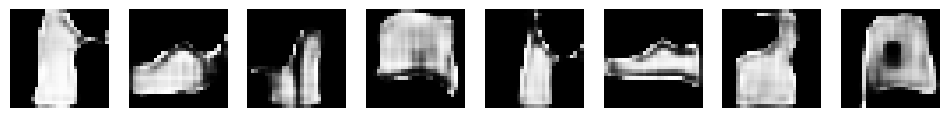

Step 4800: d_loss 0.4955 g_loss 0.9840 Accracy. real: 0.825 fake: 0.775


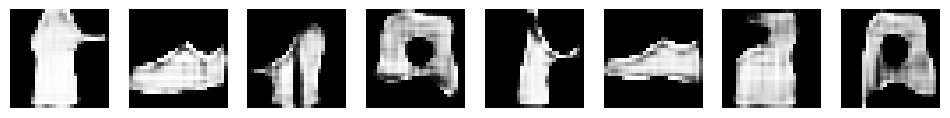

Step 5400: d_loss 0.5140 g_loss 1.3250 Accracy. real: 0.580 fake: 0.960


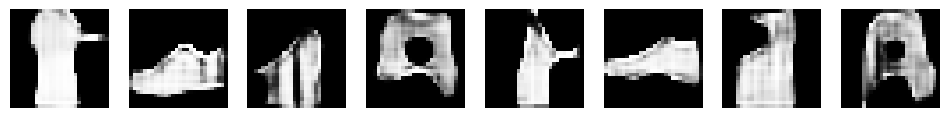

Step 6000: d_loss 0.5621 g_loss 0.6707 Accracy. real: 0.885 fake: 0.455


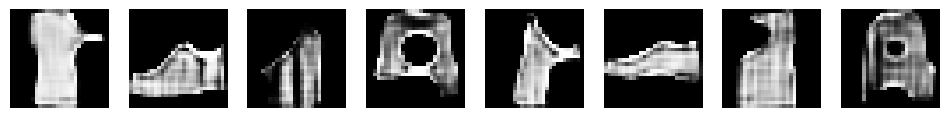

Step 6600: d_loss 0.5336 g_loss 0.8369 Accracy. real: 0.815 fake: 0.705


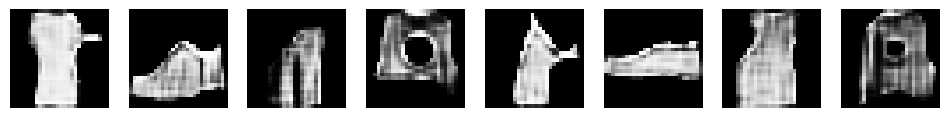

Step 7200: d_loss 0.5443 g_loss 1.2028 Accracy. real: 0.605 fake: 0.885


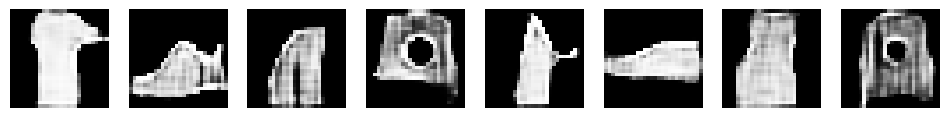

In [44]:
gan.train(iter(ds_train), z_gen, RMSprop(3e-4), RMSprop(3e-4), 25*train_steps_per_epoch, 2*train_steps_per_epoch)

Text(0.5, 0, 'Steps')

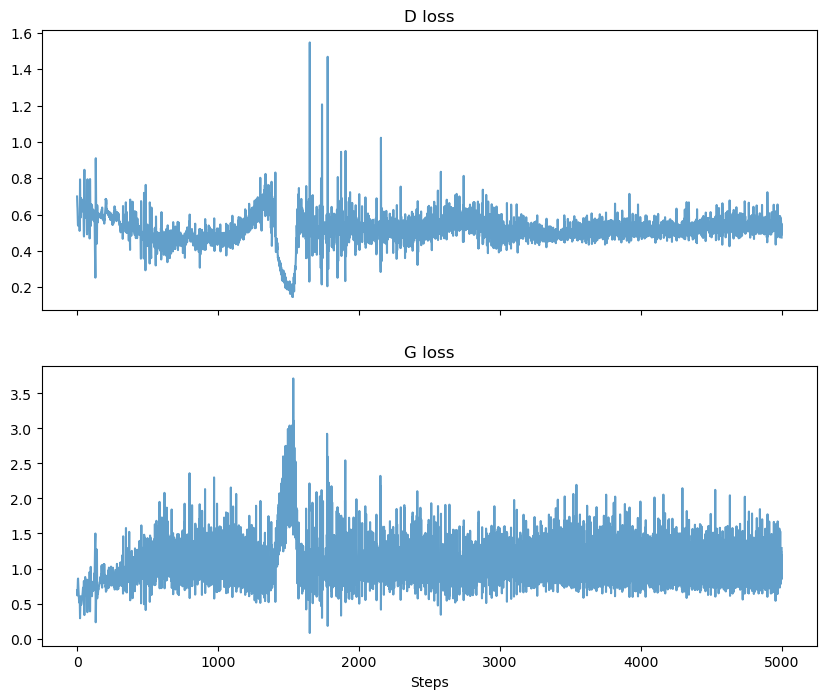

In [45]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True)
fig.set_figwidth(10)
fig.set_figheight(8)
ax1.plot(list(gan.d_loss.values())[:5000], label='D loss', alpha=0.7)
ax1.set_title('D loss')
ax2.plot(list(gan.g_loss.values())[:5000], label='G loss', alpha=0.7)
ax2.set_title('G loss')

plt.xlabel('Steps')

In [46]:
ds_train, ds_info = tfds.load('mnist', split='train', shuffle_files=True, with_info=True)
ds_train = ds_train.map(preprocess).cache().shuffle(ds_info.splits['train'].num_examples).batch(batch_size).repeat()

In [47]:
mnist_gan = DCGAN(z_dim, image_shape)

Step 0: d_loss 0.6626 g_loss 0.6799 Accracy. real: 0.940 fake: 0.000


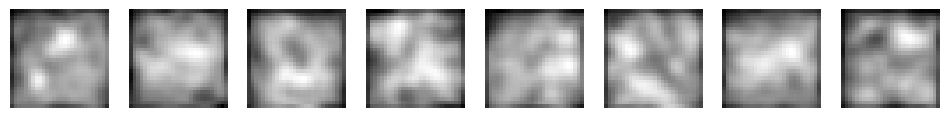

Step 300: d_loss 0.0001 g_loss 9.8986 Accracy. real: 1.000 fake: 1.000


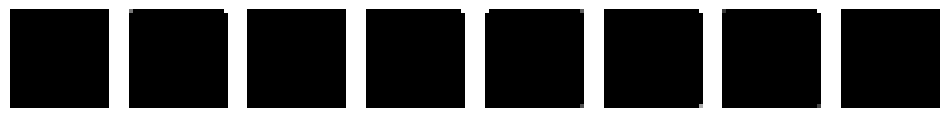

Step 600: d_loss 0.0000 g_loss 11.5401 Accracy. real: 1.000 fake: 1.000


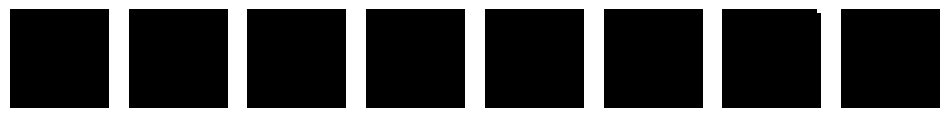

Step 900: d_loss 0.0000 g_loss 15.3837 Accracy. real: 1.000 fake: 1.000


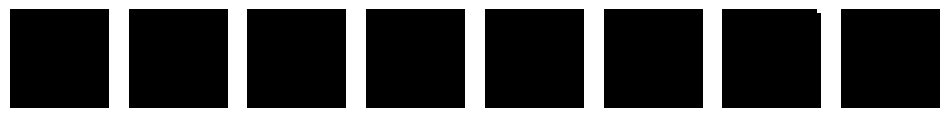

Step 1200: d_loss 0.0004 g_loss 14.8161 Accracy. real: 1.000 fake: 1.000


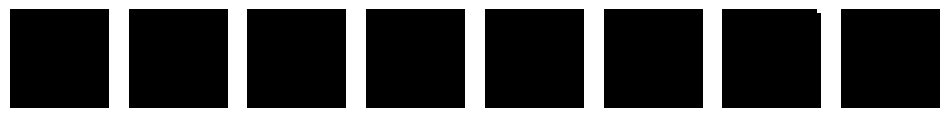

Step 1500: d_loss 0.0000 g_loss 15.8600 Accracy. real: 1.000 fake: 1.000


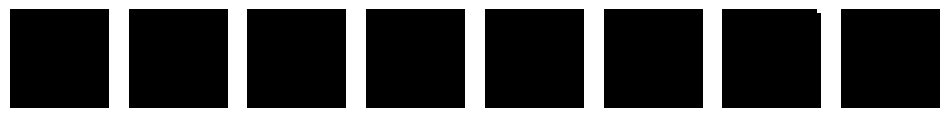

Step 1800: d_loss 0.0000 g_loss 16.6692 Accracy. real: 1.000 fake: 1.000


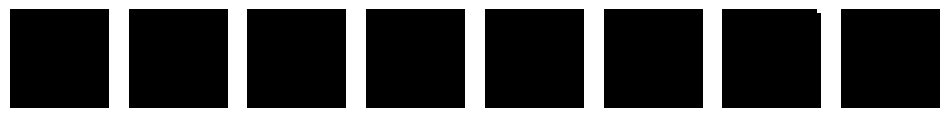

Step 2100: d_loss 0.0000 g_loss 15.8138 Accracy. real: 1.000 fake: 1.000


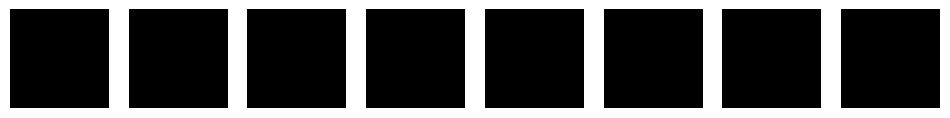

Step 2400: d_loss 0.0000 g_loss 20.3927 Accracy. real: 1.000 fake: 1.000


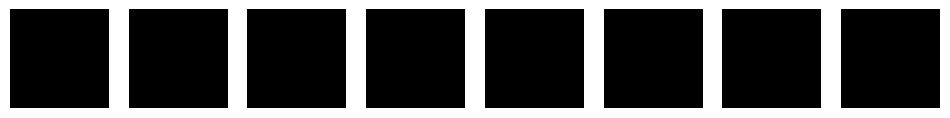

Step 2700: d_loss 0.0000 g_loss 19.7407 Accracy. real: 1.000 fake: 1.000


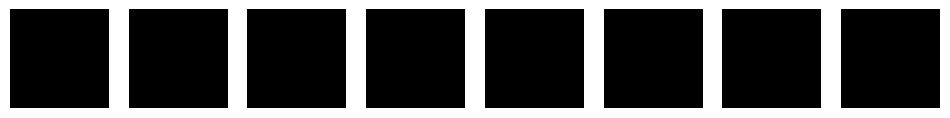

In [48]:
mnist_gan.train(iter(ds_train), z_gen,
                RMSprop(2e-4), RMSprop(2e-4),
                10*train_steps_per_epoch,
                1*train_steps_per_epoch)

In [49]:
mnist_gan = DCGAN(z_dim, image_shape)

Step 0: d_loss 0.6532 g_loss 0.6936 Accracy. real: 1.000 fake: 0.625


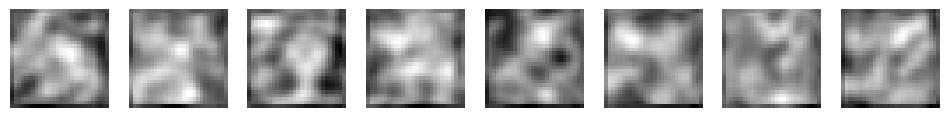

Step 300: d_loss 0.4268 g_loss 1.3762 Accracy. real: 0.755 fake: 0.970


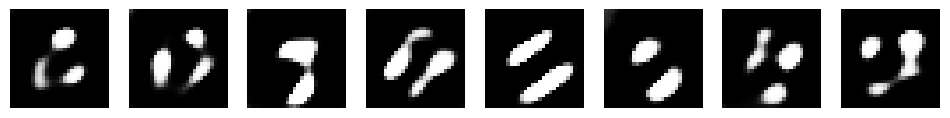

Step 600: d_loss 0.6064 g_loss 0.9585 Accracy. real: 0.660 fake: 0.775


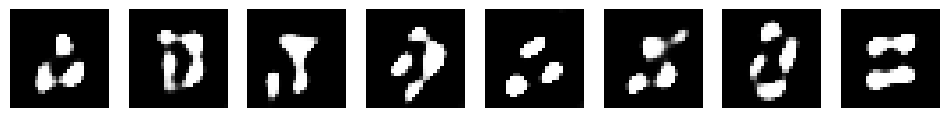

Step 900: d_loss 0.5925 g_loss 1.0395 Accracy. real: 0.520 fake: 0.910


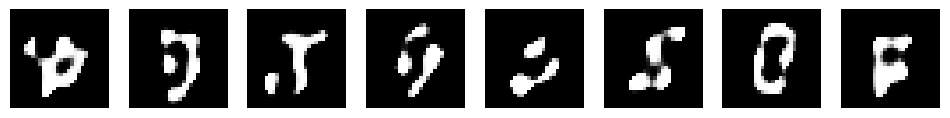

Step 1200: d_loss 0.6006 g_loss 0.8924 Accracy. real: 0.615 fake: 0.840


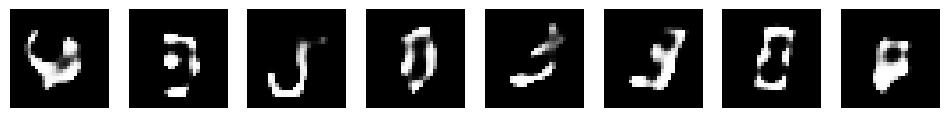

Step 1500: d_loss 0.6211 g_loss 0.8748 Accracy. real: 0.565 fake: 0.825


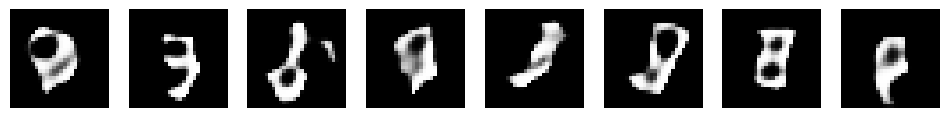

Step 1800: d_loss 0.6024 g_loss 0.7542 Accracy. real: 0.785 fake: 0.585


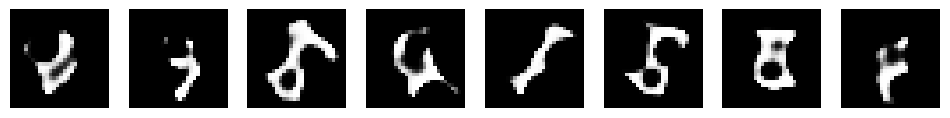

Step 2100: d_loss 0.6560 g_loss 1.0365 Accracy. real: 0.245 fake: 0.935


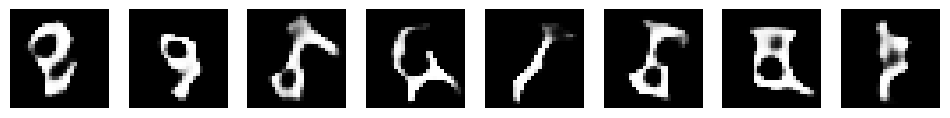

Step 2400: d_loss 0.6422 g_loss 0.6953 Accracy. real: 0.790 fake: 0.505


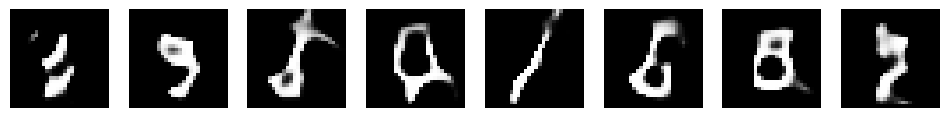

Step 2700: d_loss 0.6350 g_loss 0.7811 Accracy. real: 0.670 fake: 0.725


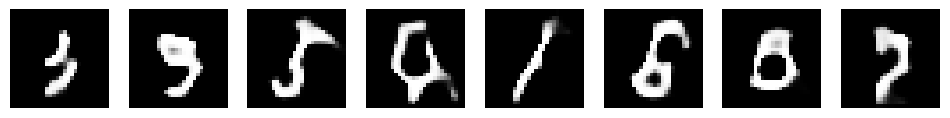

In [50]:
mnist_gan.train(iter(ds_train), z_gen,
                RMSprop(2e-4), RMSprop(2e-4),
                10*train_steps_per_epoch,
                1*train_steps_per_epoch)

Step 0: d_loss 0.6419 g_loss 0.6399 Accracy. real: 0.915 fake: 0.285


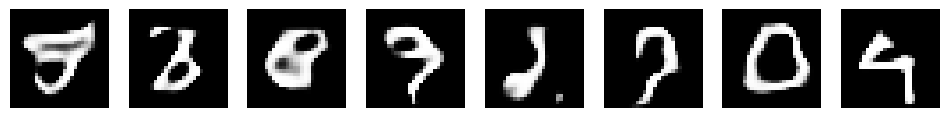

Step 300: d_loss 0.6507 g_loss 0.6283 Accracy. real: 0.910 fake: 0.285


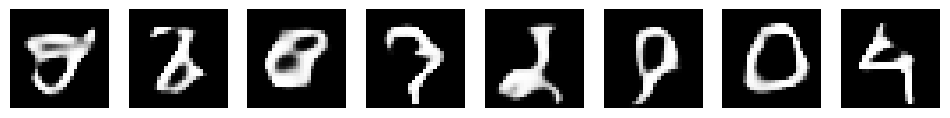

Step 600: d_loss 0.6511 g_loss 0.8850 Accracy. real: 0.365 fake: 0.890


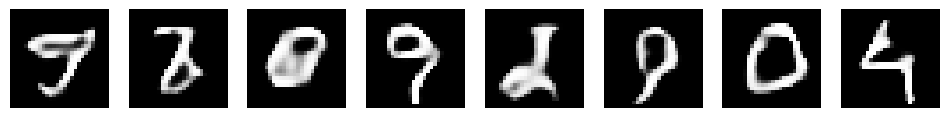

Step 900: d_loss 0.6432 g_loss 0.6558 Accracy. real: 0.875 fake: 0.350


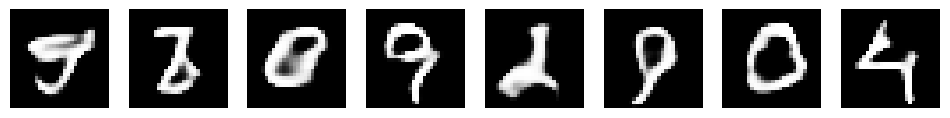

Step 1200: d_loss 0.6443 g_loss 0.6107 Accracy. real: 0.940 fake: 0.250


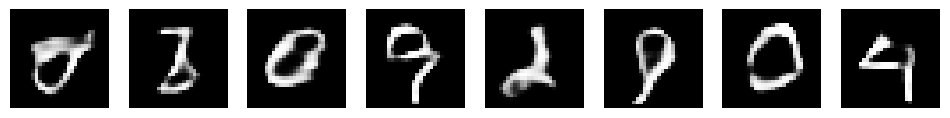

Step 1500: d_loss 0.6391 g_loss 0.6450 Accracy. real: 0.910 fake: 0.335


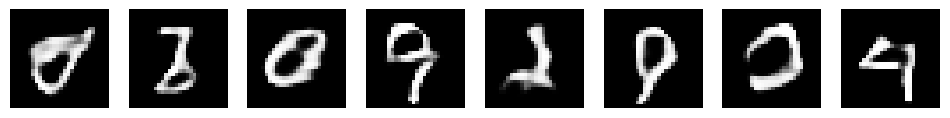

Step 1800: d_loss 0.6388 g_loss 0.9124 Accracy. real: 0.450 fake: 0.910


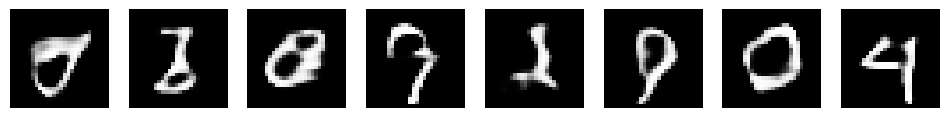

Step 2100: d_loss 0.6304 g_loss 0.9654 Accracy. real: 0.385 fake: 0.935


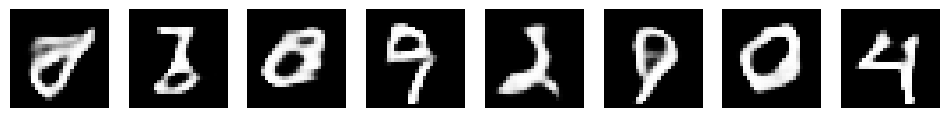

Step 2400: d_loss 0.6208 g_loss 0.9030 Accracy. real: 0.485 fake: 0.915


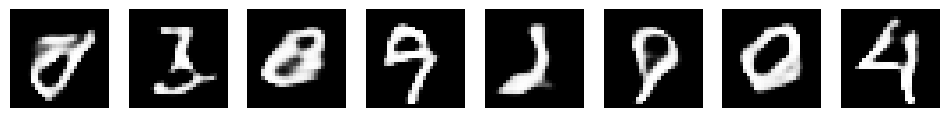

Step 2700: d_loss 0.6265 g_loss 1.1171 Accracy. real: 0.210 fake: 0.995


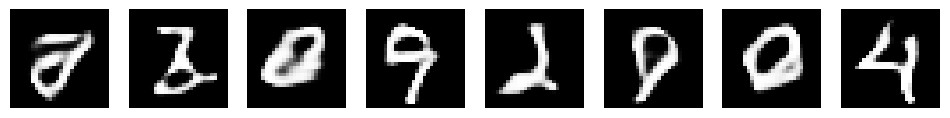

In [51]:
mnist_gan.train(iter(ds_train), z_gen,
                RMSprop(2e-4), RMSprop(2e-4),
                10*train_steps_per_epoch,
                1*train_steps_per_epoch)